In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
# create datasets
def generate_in_distribution_data(n, mu, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    X_0 = np.random.multivariate_normal(mu_0, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(mu_1, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, pi_out, theta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    X_0 = np.random.multivariate_normal(np.matmul(R, mu_0.T).T, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(np.matmul(R, mu_1.T).T, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

## Bivariate Single-Head LDA

Consider a generic binary LDA aimed at learning the target task. The projection vector is estimated according to the following expression:

$$ \omega = \argmax_{\omega} \frac{(\omega^\top \bar{X}_1 - \omega^\top \bar{X}_0 )^2}{\omega^\top S_w \omega} $$

where, 

$$ S_w = \frac{n_1 S_{1} + n_0 S_{0}}{n} $$

Here, $S_{1}, S_{0}, {X}_{0}, \bar{X}_{1}$ are sample covariance matrices of target class 1 and target class 0, and sample means of target class 0 and class 1 respectively. 

The above maximization problem yields the following expression for the projection vector:

$$ \omega = (S_0 + S_1)^{-1}(\bar{X}_1 - \bar{X}_0) $$

After the projection vector is estimated, the threshold $c$ is estimated by, 

$$ c = \frac{\omega^\top \bar{X}_{0} + \omega^\top \bar{X}_{1}}{2} $$

Now consider an OOD task that has the same label distribution as the target task. We feed a mxiture (naively combined) of target and OOD data into our generic LDA. Hence, the class sample covariances and class sample means are estimated using this mixture, instead of just the target data.


In [16]:
def compute_singlehead_decision_rule(X_in, Y_in, X_out, Y_out):

    X = np.concatenate((X_in, X_out), axis=-1)
    Y = np.concatenate((Y_in, Y_out))

    X_0 = X[:, Y == 0]
    X_0_bar = np.mean(X_0, axis=-1, keepdims=True)
    X_centered = X_0 - X_0_bar
    S_0 = np.matmul(X_centered, X_centered.T)/len(Y[Y==0])

    X_1 = X[:, Y == 1]
    X_1_bar = np.mean(X_1, axis=-1, keepdims=True)
    X_centered = X_1 - X_1_bar
    S_1 = np.matmul(X_centered, X_centered.T)/len(Y[Y==1])

    omega = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    # estimate threshold
    X_projected = np.matmul(omega.T, X).squeeze()
    c = (np.mean(X_projected[Y == 0]) + np.mean(X_projected[Y == 1]))/2
    
    return omega, c

def compute_empirical_risk(X, Y, omega, c):
    Y_pred = (np.matmul(omega.T, X) > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def visualize_projection_vector(n, m, theta, mu=3, pi_in=0.5, pi_out=0.5):
    X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
    X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
    omega, c = compute_singlehead_decision_rule(X_in, Y_in, X_out, Y_out)

    m = omega[1]/omega[0]
    x = np.arange(-5, 5, 0.1)
    y = m*x

    fig, ax = plt.subplots()
    ax.scatter(X_in[:, Y_in==0][0, :], X_in[:, Y_in==0][1, :], c='b')
    ax.scatter(X_in[:, Y_in==1][0, :], X_in[:, Y_in==1][1, :], c='b')
    ax.scatter(X_out[:, Y_out==0][0, :], X_out[:, Y_out==0][1, :], c='r')
    ax.scatter(X_out[:, Y_out==1][0, :], X_out[:, Y_out==1][1, :], c='r')
    ax.plot(x, y, 'k')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 3,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
            
            for theta in Theta:
                X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
                omega, c = compute_singlehead_decision_rule(X_in, Y_in, X_out, Y_out)
                df.at[i, str(theta)] = compute_empirical_risk(X_test, y_test, omega, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Theta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Theta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

### Visual the Estimated Projection Vectors

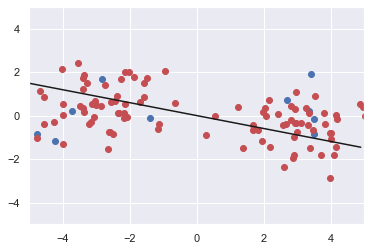

In [17]:
visualize_projection_vector(
    n=10,
    m=100,
    theta=10
)

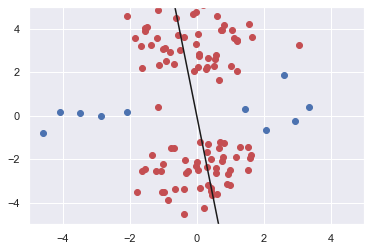

In [85]:
visualize_projection_vector(
    n=10,
    m=100,
    theta=90
)

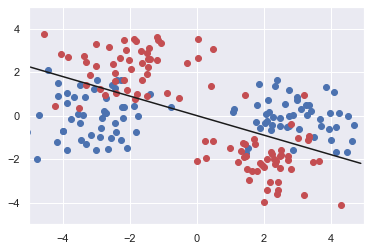

In [19]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=45
)

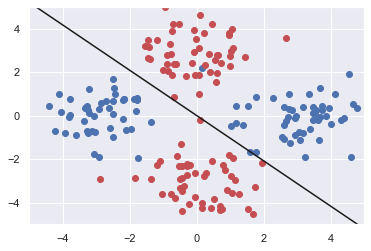

In [20]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=90
)

### Simulations

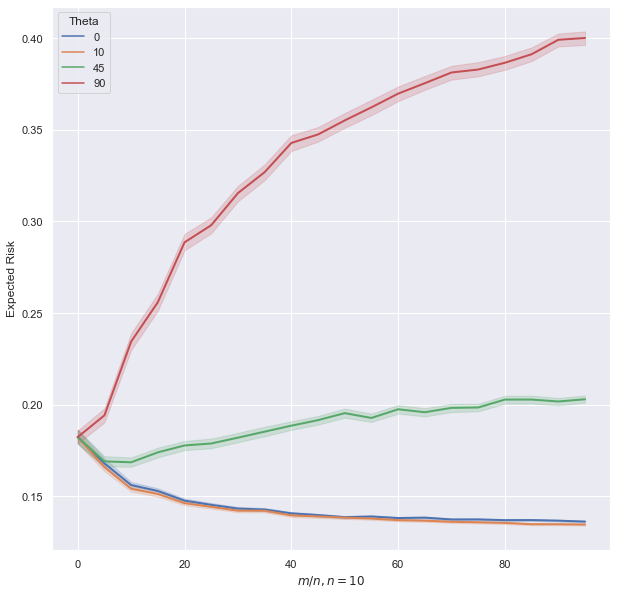

In [21]:
df = run_simulation(
    n = 10,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 100, 5),
    reps = 1000,
)

## Bivariate Multi-Head LDA

In the multi-head LDA, first a projection vector is learnt using both the target ($n$) and OOD ($m$) data. In our case, we consider target and OOD tasks to be both binary classification tasks. Hence, there are four classes in total. Under these conditions, the projection vector is estimated according to the following expression (frequently used in the multi-class LDA):

$$ \omega = \argmax_{\omega} \frac{\omega^\top S_b \omega}{\omega^\top S_w \omega} $$

where, 

$$ S_b = \frac{1}{n+m} \sum_{i=1}^{n+m} (X_i - \bar{X}) (X_i - \bar{X})^\top $$
$$ S_b = \sum_{k=1}^K N_k (\hat m_k - \hat m) (\hat m_k - \hat m)^T$$
$$ S_w = \frac{n_1 S_{t1} + n_0 S_{t0} + m_1 S_{o1} + m_0 S_{o0}}{n+m} $$

Here, $S_{t1}, S_{t0}, S_{o1}, S_{o0}$ are sample covariance matrices of target class 1, target class 0, OOD class 1, and OOD class 0, repectively.

The above maximization problem yields that the projection vector is the eigenvector corresponding to $\lambda_{max}(S_w^{-1} S_b)$.

After the projection vector is estimated, the threshold $c_{in}$ is estimated by, 

$$ c_{in} = \frac{\omega^\top \bar{X}_{t0} + \omega^\top \bar{X}_{t1}}{2} $$

where $\bar{X}_{t0}, \bar{X}_{t1}$ are sample means of target class 0 and class 1 respectively.


In [3]:
# support functions
def generate_in_distribution_data(n, mu, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    X_0 = np.random.multivariate_normal(mu_0, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(mu_1, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, pi_in, theta):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    X_0 = np.random.multivariate_normal(np.matmul(R, mu_0.T).T, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(np.matmul(R, mu_1.T).T, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out):
    N = len(Y_in) + len(Y_out)

    X_in_0 = X_in[:, Y_in == 0]
    X_in_0_bar = np.nan_to_num(np.mean(X_in_0, axis=-1, keepdims=True))
    X_centered = X_in_0 - X_in_0_bar
    S_w_in_0 = np.matmul(X_centered, X_centered.T)

    X_in_1 = X_in[:, Y_in == 1]
    X_in_1_bar = np.nan_to_num(np.mean(X_in_1, axis=-1, keepdims=True))
    X_centered = X_in_1 - X_in_1_bar
    S_w_in_1 = np.matmul(X_centered, X_centered.T)

    X_out_0 = X_out[:, Y_out == 0]
    X_out_0_bar = np.nan_to_num(np.mean(X_out_0, axis=-1, keepdims=True))
    X_centered = X_out_0 - X_out_0_bar
    S_w_out_0 = np.matmul(X_centered, X_centered.T)

    X_out_1 = X_out[:, Y_out == 1]
    X_out_1_bar = np.nan_to_num(np.mean(X_out_1, axis=-1, keepdims=True))
    X_centered = X_out_1 - X_out_1_bar
    S_w_out_1 = np.matmul(X_centered, X_centered.T)

    S_w = (S_w_in_0 + S_w_in_1 + S_w_out_0 + S_w_out_1)/N

    # S_b according to "A generalization of LDA in MLE framework"
    X = np.concatenate((X_in, X_out), axis=-1)
    X_bar = np.mean(X, axis=-1, keepdims=True)
    X_centered = X - X_bar
    S_b = np.matmul(X_centered, X_centered.T)/N

    # S_b according to Bishop's Book + other sources
    m_k = np.concatenate((X_in_0_bar, X_in_1_bar, X_out_0_bar, X_out_1_bar), axis=-1)
    m_k_centered = m_k - np.mean(m_k, axis=-1, keepdims=True)
    S_bn = len(Y_in[Y_in==0])*np.matmul(m_k_centered[:, [0]], m_k_centered[:, [0]].T) +\
           len(Y_in[Y_in==1])*np.matmul(m_k_centered[:, [1]], m_k_centered[:, [1]].T) +\
           len(Y_out[Y_out==0])*np.matmul(m_k_centered[:, [2]], m_k_centered[:, [2]].T) +\
           len(Y_out[Y_out==1])*np.matmul(m_k_centered[:, [3]], m_k_centered[:, [3]].T)
    S_bn /= N

    # estimate projection vector
    e, v = np.linalg.eig(np.matmul(np.linalg.inv(S_w), S_bn))
    omega = v[:, np.argmax(e)].reshape(2, 1)
    
    # estimate threshold
    X_in_projected = np.matmul(omega.T, X_in).squeeze()
    c_in = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2
    
    return omega, c_in

def compute_empirical_risk(X, Y, omega, c):
    Y_pred = (np.matmul(omega.T, X) > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def visualize_projection_vector(n, m, theta, mu=3, pi_in=0.5, pi_out=0.5):
    X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
    X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
    omega, c = compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out)

    m = omega[1]/omega[0]
    x = np.arange(-5, 5, 0.1)
    y = m*x

    fig, ax = plt.subplots()
    ax.scatter(X_in[:, Y_in==0][0, :], X_in[:, Y_in==0][1, :], c='b')
    ax.scatter(X_in[:, Y_in==1][0, :], X_in[:, Y_in==1][1, :], c='b')
    ax.scatter(X_out[:, Y_out==0][0, :], X_out[:, Y_out==0][1, :], c='r')
    ax.scatter(X_out[:, Y_out==1][0, :], X_out[:, Y_out==1][1, :], c='r')
    ax.plot(x, y, 'k')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 3,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
            
            for theta in Theta:
                X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
                omega, c = compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out)
                df.at[i, str(theta)] = compute_empirical_risk(X_test, y_test, omega, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Theta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Theta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

### Visualize the Estimated Projection Vector

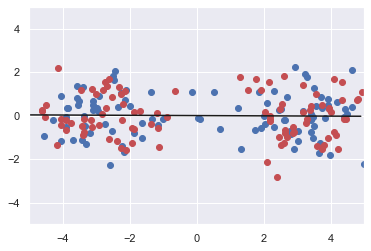

In [113]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=0
)

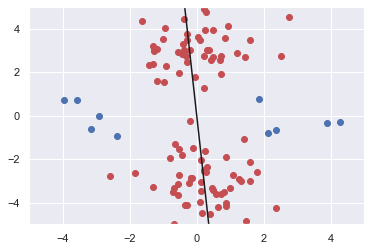

In [114]:
visualize_projection_vector(
    n=10,
    m=100,
    theta=90
)

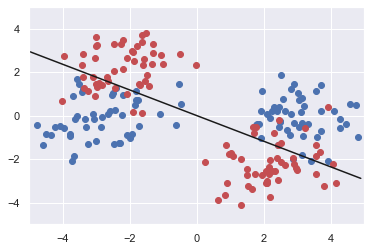

In [115]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=45
)

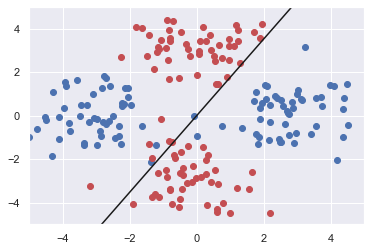

In [116]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=90
)

### Simulations

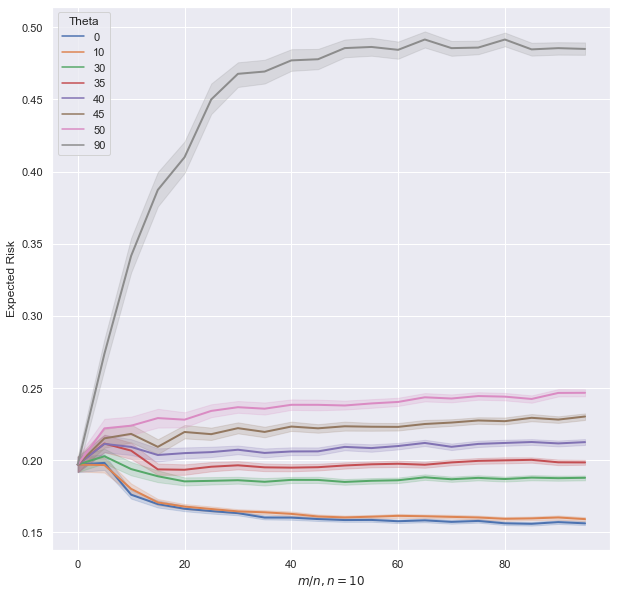

In [5]:
df = run_simulation(
    n = 10,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 30, 35, 40, 45, 50, 90],
    m_sizes = np.arange(0, 100, 5),
    reps = 1000,
)